# Feature Importance - Zachary Barnes

In [8]:
%run featimp.py
%matplotlib inline
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Feature importance is a set of techniques for evaluating how valuable/effective features in your data are. We loosely define two objectives for feature importance:

- Choosing features to increase model performance 
- Understanding which features are influential relative to the others

This report is organized into two sections:

1. Implementing feature importance strategies
2. Exploring more advanced feature importance libraries

At the end we explore the feature importance packages SHAP, LIME, and PDPBOX (for partial dependence plots)

## Data Sets

To have a way to compare techniques, we will be constraining the type of problem and dataset. We will only look at regression problems, and will be using two housing data sets. 

The first dataset is the Boston housing dataset, with 13 features. Each row is a Boston suburb or town. The target y is the median value of a home in that town. This is a tiny data set, with 506 observations. 

In [9]:
X, y = boston()
X.shape

(506, 13)

In [10]:
X, y = cali()
X.shape

(20640, 8)

For a larger dataset and different features, we will also be using the California housing data set. This data was collected from the 1990 US census. 
This data set has 8 features, but now each row is now a census block. We are predicting the median home value for each census block.

# Feature importance without a model

It can be valuable to look at feature importance without a model. In this section, we will be looking at two techniques for looking at feature importance: Spearman's Rank Coefficient, Principle Component analysis.

## Spearman's Rank Coefficient

This is a statistic is that is computed in two steps:
- Rank (order) each value in a feature 
- Compute the correlation coefficient between two ranked vectors

It can be useful to see the coefficient between features in our data, but for now we will only look at the coefficient compared to our target feature.

Here is the most general definition of Spearman's rank coefficient:

 $$r_s =
 \rho_{\operatorname{rg}_X,\operatorname{rg}_Y} =
 \frac{\operatorname{cov}(\operatorname{rg}_X, \operatorname{rg}_Y)}
      {\sigma_{\operatorname{rg}_X} \sigma_{\operatorname{rg}_Y}},$$

Where rg is the ranked vectors, cov is the covariance between those vectors, and $\sigma_{rg_{x}}$ is the standard deviation of a ranked vector. 

If all values are distinct, we can use this version as a definition:

$$r_s = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}$$

But this is rarely the case. We'll then stick with the more general formula.

Ranking data at first seems straightforward, but when you have duplicates, you must consider how to deal with duplicate values. There are many techniques to handle this, the most common being to assign the average of the ranks that would have been assigned to all the tied values. 

Scipy has a rankdata() function that implements this functionality for us. Here is an example:

In [17]:
rankdata(np.array([1,2,3,4,1]))

array([1.5, 3. , 4. , 5. , 1.5])

We see that 1 was given a ranking of 1.5 while 2 was given a ranking of 3.

In [18]:
rankdata(np.array([1,2,1,3,4,1]))

array([2., 4., 2., 5., 6., 2.])

When there is 3 ones, now we see that 1 is given a ranking of 2.

With this functionality, it is simply a matter of using numpy's corrcoef to calculate the correlation:

In [19]:
X, y = boston()

In [20]:
np.corrcoef(rankdata(X['LSTAT']), rankdata(y))

array([[ 1.        , -0.85291414],
       [-0.85291414,  1.        ]])

The corrcoef function returns the covariance matrix, and for the case of one feature compared with the target, we just need a value off the diagonal:

In [21]:
np.corrcoef(rankdata(X['LSTAT']), rankdata(y))[0][1]

-0.8529141394922164

Let's turn this functionality into a function, which we can now use to generate all coefficents of the features with respect to the target:

In [22]:
corr_coef = lambda x,y : np.corrcoef(rankdata(x), rankdata(y))[0][1]
sorted(zip(np.array([corr_coef(row,y) for row in X.values.T]), X.columns))

[(-0.8529141394922164, 'LSTAT'),
 (-0.5782553852030439, 'INDUS'),
 (-0.5626088297953195, 'NOX'),
 (-0.5624106263737141, 'TAX'),
 (-0.5588909488368801, 'CRIM'),
 (-0.5559046822691174, 'PTRATIO'),
 (-0.5475616874543465, 'AGE'),
 (-0.3467762570566875, 'RAD'),
 (0.14061215382621473, 'CHAS'),
 (0.18566412252480774, 'B'),
 (0.4381789640559852, 'ZN'),
 (0.4458568541441563, 'DIS'),
 (0.6335764254337745, 'RM')]

We now observe that some features have strong negative correlation, while others have strong positive. LSTAT, the feature with the highest absolute coefficent, stands for "lower status", the percentage of the town that is a lower status of the population (according to the data dictionary). This makes sense then that it would be negatively correlated with the median housing value, since the higher this proportion, the lower the housing value. 

 This is important to be aware of, but for the purposes of feature importance this is a detail that can be over looked. Therefore for our final function we take the absolute value of each coefficient but leave as an option to also look at negative correlations:

In [23]:
spear_rank_coef(X,y)

[(0.14061215382621473, 'CHAS'),
 (0.18566412252480774, 'B'),
 (0.3467762570566875, 'RAD'),
 (0.4381789640559852, 'ZN'),
 (0.4458568541441563, 'DIS'),
 (0.5475616874543465, 'AGE'),
 (0.5559046822691174, 'PTRATIO'),
 (0.5588909488368801, 'CRIM'),
 (0.5624106263737141, 'TAX'),
 (0.5626088297953195, 'NOX'),
 (0.5782553852030439, 'INDUS'),
 (0.6335764254337745, 'RM'),
 (0.8529141394922164, 'LSTAT')]

In [24]:
spear_rank_coef(X,y, abs_val=False)

[(-0.8529141394922164, 'LSTAT'),
 (-0.5782553852030439, 'INDUS'),
 (-0.5626088297953195, 'NOX'),
 (-0.5624106263737141, 'TAX'),
 (-0.5588909488368801, 'CRIM'),
 (-0.5559046822691174, 'PTRATIO'),
 (-0.5475616874543465, 'AGE'),
 (-0.3467762570566875, 'RAD'),
 (0.14061215382621473, 'CHAS'),
 (0.18566412252480774, 'B'),
 (0.4381789640559852, 'ZN'),
 (0.4458568541441563, 'DIS'),
 (0.6335764254337745, 'RM')]

This format of tuples of feature importance with the column name will be the basis for all our importances, and will work with our plot_importances function:

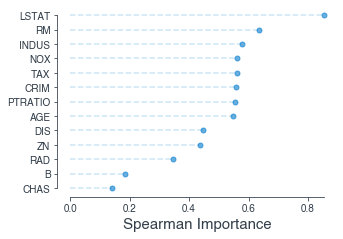

In [25]:
plot_importances(spear_rank_coef(X,y), imp_type='Spearman')

For the california housing data set, we observe Median Income to have the highest absolute correlation with the target.

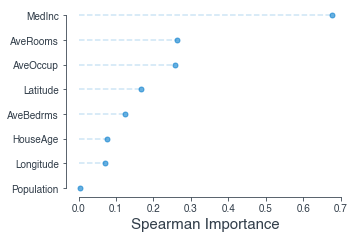

In [26]:
X, y = cali()
plot_importances(spear_rank_coef(X,y),imp_type='Spearman')

## Principle Components Analysis (PCA)

Step of this algorithm from [here](https://github.com/brianspiering/ml_lab/blob/master/6_dimension_reduction/2_pca_algorithm.ipynb)

PCA is a powerful dimenstionality reduction technique, but is also useful for understanding data without a model. A very general description of PCA is that it tells us the amount of variance each feature 'explains'. The procedure is as follows:

1. Normalize the data to have a mean of 0 and standard deviation of 1.
2. Compute the covariance matrix sigma:
$$\Sigma=\frac{1}{m}\sum_{i=1}^mx^{(i)}{x^{(i)}}^T\in\mathbb{R}^{n\times n}$$
3. Compute the eigenvectors and eigenvalues of the covariance matrix.

Each eigenvector is called a Principal Component, a direction in feature space.
Each eigenvalue is the amount of variance along its corresponding eigenvector.



We will use scikit learn's implementation of PCA, which decides the number of principle components to use as n_components == min(n_samples, n_features) - 1

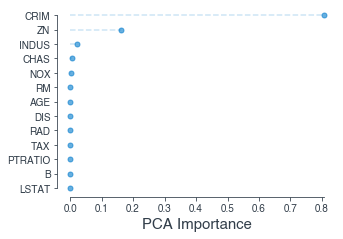

In [27]:
X, y = boston()
plot_importances(pca_imp(X), imp_type='PCA')

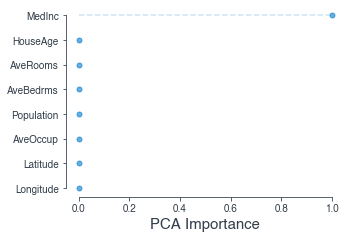

In [28]:
X, y = cali()
plot_importances(pca_imp(X), imp_type='PCA')

We see that unlike spearman's rank coefficient, for the Boston data set LSTAT was not significant. For the california housing data, it agreed with spearman's rank coefficient by showing Median Income (MedInc) as significant.

Now we look at two general techniques that work for any model: drop column and permutation importance.

## Drop Column Importance

Here are the steps to implement drop column importance:
1. Split your data into training and test data
2. Fit your model on the training data
3. Calculate the baseline metric on the TEST set
4. For each column, drop it from the training data, and train a new model on this dropped subset. 
5. Predict on the test data with the fitted model, and calculate the new metric 
6. The difference between the baseline and new metric is the feature importance. 

It is important to note that here, we are using the test set to generate our new metric to compare to the baseline. There are some compelling arguments for also using the training set to calculate this baseline: https://christophm.github.io/interpretable-ml-book/feature-importance.html (section 5.5.2)

However, for our purposes, we want to see how our model will generalize to unseen data, and for this reason, we compute our new metric using the test set.

To split our data into train and test data, we'll use sklearn's train_test_split:

In [29]:
X, y = boston()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Fit the model and caluculate baseline metric (here we use linear regression and R2 score):

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [32]:
m = LinearRegression()
m.fit(X_train, y_train)
baseline = r2_score(y_test, m.predict(X_test))
baseline

0.7590604894200677

Drop columns and predict on validation set, then calculate difference between baseline and new metric:

In [33]:
imp = []
for col in X_train.columns:
    X_drop = X_train.drop(col, axis=1)
    X_drop_test = X_test.drop(col, axis=1)
    drop_model = LinearRegression()
    drop_model.fit(X_drop,y_train)
    drop_metric = r2_score(y_test, drop_model.predict(X_drop_test))
    imp.append(baseline - drop_metric)
sorted(zip(imp, X.columns))

[(-0.008512342793047134, 'CRIM'),
 (-0.005501349395087729, 'NOX'),
 (-0.001968617134669115, 'INDUS'),
 (-0.001418455299927568, 'AGE'),
 (-0.001339510744876593, 'ZN'),
 (0.001956918665919627, 'RAD'),
 (0.0024081707040964906, 'B'),
 (0.006320565218125962, 'TAX'),
 (0.010661202759333799, 'CHAS'),
 (0.01746266397644669, 'PTRATIO'),
 (0.031076329681019477, 'DIS'),
 (0.06070316737833881, 'RM'),
 (0.07072111017521443, 'LSTAT')]

Now we have each feature in order of drop column importance:

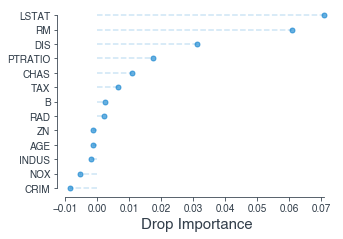

In [34]:
plot_importances(sorted(zip(imp, X.columns)), imp_type='Drop')

From the plot, we see that LSTAT is significant, agreeing with what we saw with spearman's rank correlation.

Something else to note with drop column it is possible to see negative feature importances. What this means is that the model performs better when these features are dropped.

Let's compare with two different models, Random Forest and Gradient Boosting:

In [4]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

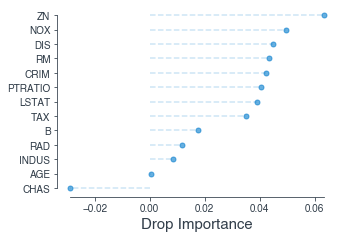

In [36]:
plot_importances(drop_column(X,y, RandomForestRegressor, r2_score), imp_type='Drop')

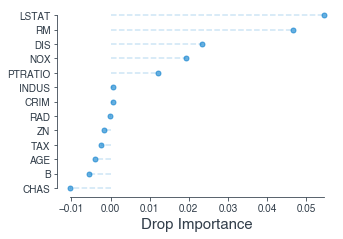

In [37]:
plot_importances(drop_column(X, y, GradientBoostingRegressor, r2_score),imp_type='Drop')

Because of the randomness in each of these tree based models, the importances themseleves vary on each run. However, for the most part, the relative rankings remain the same. LSTAT consistently comes to the top.

In [38]:
X, y = cali()

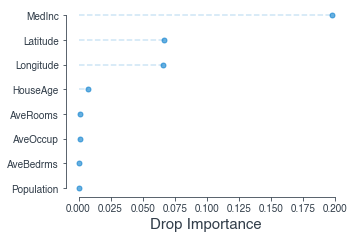

In [39]:
plot_importances(drop_column(X, y, LinearRegression, r2_score), imp_type='Drop')

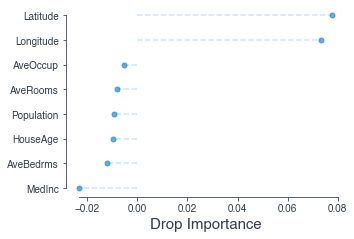

In [40]:
plot_importances(drop_column(X,y, RandomForestRegressor, r2_score), imp_type='Drop')

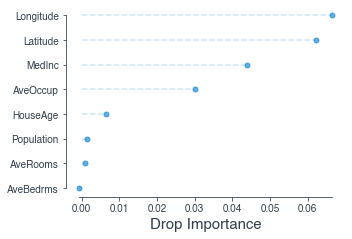

In [41]:
plot_importances(drop_column(X, y, GradientBoostingRegressor, r2_score), imp_type='Drop')

With the california housing data set, it is interesting to note that while LinearRegression and GradientBoostingRegression empahzie MedInc, RandomForest consistently has MedInc as the least important feature. This is an example of when using different models with the same feature importance technique can bring about different results.

## Permutation Importance

Permutation importance is very similar to drop column, with the key difference being instead of dropping a column and retraining the model, the model is fit once, and predict on the versions of the test data where one column is randomly permuted row wise. This can result in some strange features for each row (males pregnancies) but has the advantage over drop column in that we only have to train the model once.

In [42]:
X, y = boston()

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [44]:
m = LinearRegression()
m.fit(X_train, y_train)
baseline = r2_score(y_test, m.predict(X_test))
baseline

0.699834592719726

Permute columns and predict on validation set, then calculate difference between baseline and new metric:

In [45]:
imp = []
for col in X_train.columns:
        save = X_test[col].copy()
        X_test.loc[:,col] = np.random.permutation(X_test[col])
        perm_metric = r2_score(y_test, m.predict(X_test))
        X_test.loc[:, col] = save
        imp.append(baseline - perm_metric)
sorted(zip(imp, X.columns))

[(-0.00310178821404572, 'CHAS'),
 (0.002417677162987353, 'INDUS'),
 (0.00765602836169621, 'AGE'),
 (0.016478546638704072, 'CRIM'),
 (0.033593026454919905, 'ZN'),
 (0.03387240158082827, 'B'),
 (0.10774610065630696, 'TAX'),
 (0.12926249784665944, 'PTRATIO'),
 (0.14315127464851318, 'NOX'),
 (0.14383468885849549, 'RM'),
 (0.14559897872041172, 'RAD'),
 (0.2402076476979792, 'DIS'),
 (0.32189134795590657, 'LSTAT')]

As with drop column, we also observe the LSTAT is the most important feature defined by permuation importance.

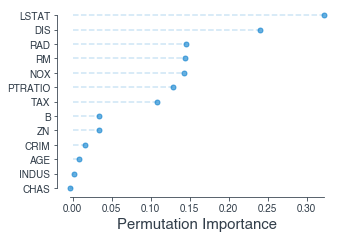

In [46]:
plot_importances(sorted(zip(imp, X.columns)), imp_type='Permutation')

Comparing with Random Forest and Gradient Boosting:

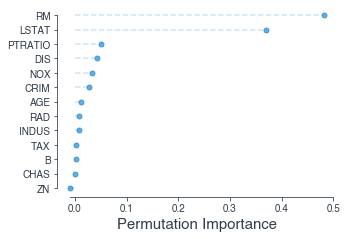

In [47]:
plot_importances(perm_imp(X, y, RandomForestRegressor, r2_score), imp_type='Permutation')

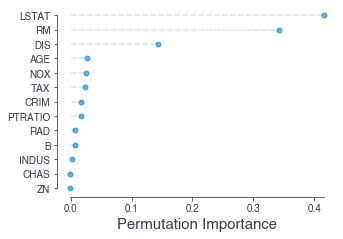

In [48]:
plot_importances(perm_imp(X, y, GradientBoostingRegressor, r2_score), imp_type='Permutation')

Let's also look at the california housing data set:

In [49]:
X, y = cali()

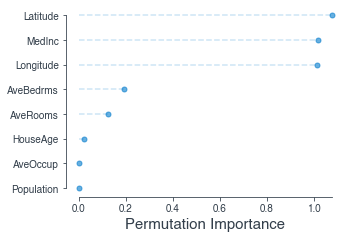

In [50]:
plot_importances(perm_imp(X, y, LinearRegression, r2_score), imp_type='Permutation')

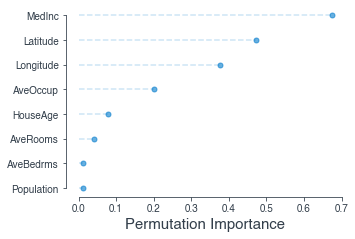

In [51]:
plot_importances(perm_imp(X, y, RandomForestRegressor, r2_score), imp_type='Permutation')

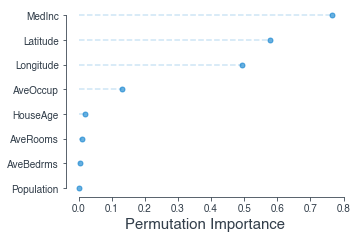

In [52]:
plot_importances(perm_imp(X, y, GradientBoostingRegressor, r2_score), imp_type='Permutation')

It is interesting to note that with permutation importance all models choose MedInc, latititude and longitude as the most important, where with drop column random forest identified MedInc as the least significant.

## Variance and Empirical P-values via Bootstrapping

To address the inherit randomness invovled in the train test split, permutation, and randomness in certain models(Random Forest, Gradient Boosting), it is helpful to have error bars on the values for feature importance. The error bars represent 2 standard deviations from the mean of the feature importances over a given number of simulations.

To do the simulations, we bootstrap our data. This is simply sampling our data with replacement, and sampling the same number of times as the original amount of observations that we have in our dataset. Another possible technique is to use random subsampling. 

To ensure that we can compare the variance of each feature, we min max scale the importances of each feature so that they are between 0 and 1.

Here we create a dictionary of features and their boostrapped importances, and save all the importances for min max scaling:

In [53]:
X, y = boston()

In [54]:
d = defaultdict(list)
all_imps = []
    
#bootstrap to simulate different data sets
for i in range(30):
    indicies = np.random.choice(X.values.shape[0], size=X.values.shape[0], replace=True)
    tup = perm_imp(X.iloc[indicies], y[indicies], RandomForestRegressor, r2_score)
    for k,v in tup:
        d[v].append(k)
        all_imps.append(k)

Min-Max scale for comparison:

In [55]:
all_imps_min = np.array(all_imps).min()
all_imps_max = np.array(all_imps).max()

for k,v in d.items():
        imp = np.array(v)
        min_max = (imp - all_imps_min)/ (all_imps_max - all_imps_min)
        d[k] = [min_max.mean(), min_max.std()]

Then, we sort our dictionary and plot the mean as the bar height and the standard deviation as the error bars:

Text(0.5, 0, 'Importance')

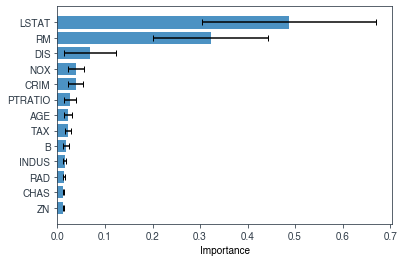

In [56]:
d = sorted(d.items(), key=lambda kv: kv[1][0])
x = [tup[0] for tup in d]
mean = [tup[1][0] for tup in d]
std = [tup[1][1] for tup in d]

plt.barh(x, mean, xerr=std, capsize=3, align='center', alpha=0.8)
plt.xlabel('Importance')

Here we see that the error bars on LSTAT and RM are quite wide compared to the other features, but the minimum of the error bars does not overlap with the the other feature's mean, or error bars. This gives us more insight in to how the model and feature importance will perform over many samples.

Now let's look at the same model but with drop column:

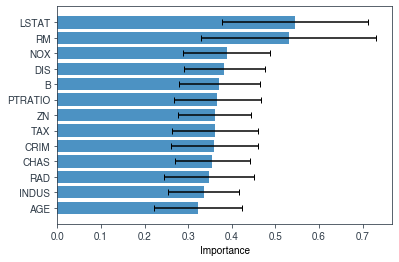

In [57]:
plot_imp_err(X, y, RandomForestRegressor, r2_score, imp_type=drop_column)

With drop column, the mean importances overlap much more than permutation, and the error bars almost all overlap.

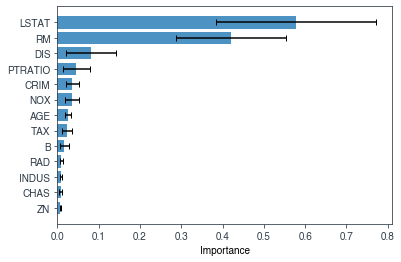

In [58]:
plot_imp_err(X, y, GradientBoostingRegressor, r2_score, imp_type=perm_imp)

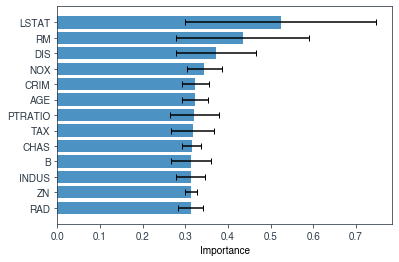

In [59]:
plot_imp_err(X, y, GradientBoostingRegressor, r2_score, imp_type=drop_column)

Let's look at the california dataset:

In [60]:
X, y = cali()

Drop column takes a signficant amount of time, so we will only look at permutation importance:

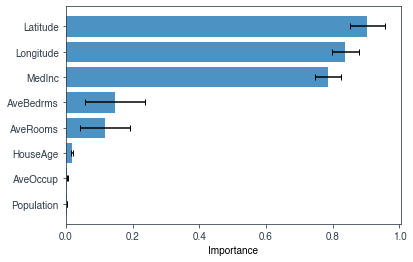

In [61]:
plot_imp_err(X, y, LinearRegression, r2_score, imp_type=perm_imp)

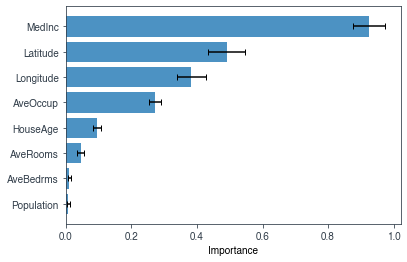

In [62]:
plot_imp_err(X, y, RandomForestRegressor, r2_score, imp_type=perm_imp)

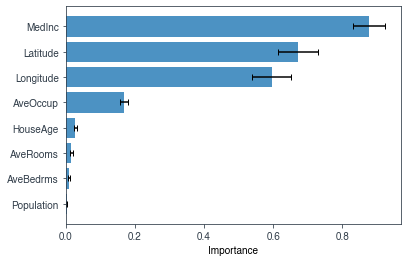

In [63]:
plot_imp_err(X, y, GradientBoostingRegressor, r2_score, imp_type=perm_imp)

With the larger dataset, the importances are more stable over 30 simulations, and more consistent across different models.

### Empirical P-values

How can we trust that features are not giving high feature importances by chance? 

One way to evalaute this is by computing empicical P-values. To do this we first compute the real feature importance. Then, for a given number of iterations, we scramble the y values and compute the feature importance on the scrambled y. We then count every time that a feature's importance is greater than the real importance, and plot this percentage. As a general cutoff, if the feature is more important than it's true importance more than 5% of time, that is cause for suspicion.

Let's first calculate the real feature importance:

In [64]:
X, y = boston()
d = defaultdict(list)
real_imp = perm_imp(X, y, RandomForestRegressor, r2_score)
real_imp = {v:k for k,v in real_imp} #for sorting purposes we'll want to switch the keys and values

Then compute importances on the scrambled y. 80 iterations seems to be decent:

In [65]:
for i in range(80):
        y = np.random.permutation(y)
        tup = perm_imp(X, y, RandomForestRegressor, r2_score)
        for k,v in tup:
            d[v].append(k)

Then calculate how many times a feature importnace was over its real importance. Numpy's where function comes in handy for this:

In [66]:
for k,v in real_imp.items():
        d[k] = np.where(np.array(d[k]) >= v, 1, 0).sum()/80

Sort and plot our values:

Text(0.5, 0, 'Empirical P-value')

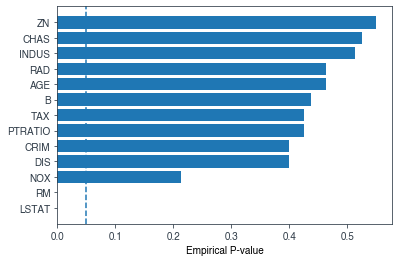

In [67]:
d = sorted(d.items(), key=lambda kv: kv[1])
x = [tup[0] for tup in d]
y = [tup[1] for tup in d]

plt.barh(x,y)
plt.axvline(x=0.05, linestyle='--')
plt.xlabel('Empirical P-value')

According to this, only LSTAT and RM are giving importances that are not suspect. 

Let's look at Gradient Boosting:

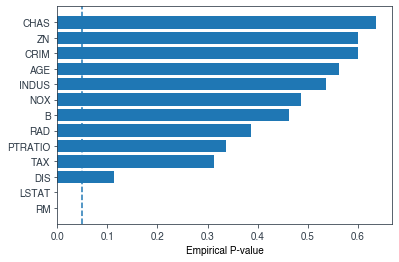

In [69]:
X, y = boston()
emp_pval(X, y, GradientBoostingRegressor, r2_score, imp_type=perm_imp)

It looks similar.

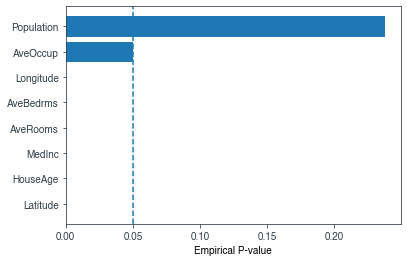

In [70]:
X, y = cali()
emp_pval(X, y, LinearRegression, r2_score, imp_type=perm_imp)

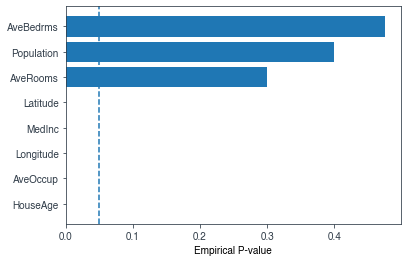

In [71]:
emp_pval(X, y, RandomForestRegressor, r2_score, imp_type=perm_imp)

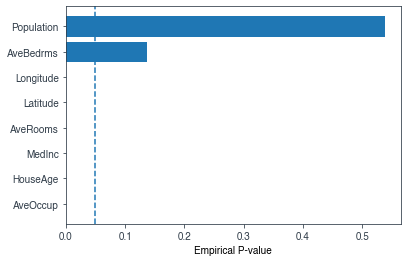

In [72]:
emp_pval(X, y, GradientBoostingRegressor, r2_score, imp_type=perm_imp)

The three models seem to agree that population will have a misleading feature importance, while average number of bedrooms and average number of rooms are possible candidates.

## Automatic Feature Selection

Looking at one of the objectives for feature importance, choosing features that make a model perform best, we develop an algorithm to automatically choose which features are worth keeping based on feature importance. 

The algorithm follows these steps:

1. Compute a baseline metric and feature importance
2. Drop the feature with the lowest feature importance
3. If the metric is better than the baseline metric, then recompute the importances without the dropped feature
4. Repeat steps 2 and 3 until the metric cannot be improved

1. Compute a baseline metric and feature importance


In [73]:
X, y = boston()

To recive the baseline for each importance type, I added in a return_baseline parameter that returns this baseline.

In [74]:
imps, baseline = perm_imp(X, y, RandomForestRegressor, r2_score, return_baseline=True)
curr_baseline = baseline

In [75]:
while curr_baseline >= baseline:
    new_features = [tup[1] for tup in imps[1:]]
    new_imps, curr_baseline = perm_imp(X[new_features], y, RandomForestRegressor, r2_score, return_baseline=True)
    if curr_baseline >= baseline:
        baseline = curr_baseline
        imps = new_imps
print(baseline)

0.8869912936410154


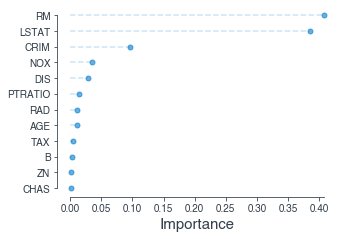

In [76]:
plot_importances(imps)

This procedure works, but I felt because of the inherent randomness in the train test split, permuatation importance, and model randonmess, that it would be a more useful algorithm if I could repeat this process, and save the best score and amount of features.

Best score 0.9189015011656592
Final features: 12/13


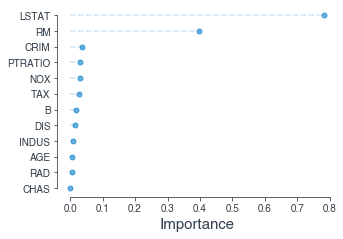

In [77]:
plot_importances(auto_selection(X,y, RandomForestRegressor, r2_score, imp_type=perm_imp))

Best score 0.9458181000940453
Final features: 12/13


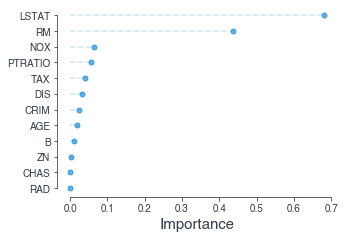

In [78]:
plot_importances(auto_selection(X,y, GradientBoostingRegressor, r2_score, imp_type=perm_imp))

Using the above procedure, we generally see higher validation score with more removal of uncessary features on the boston data set.

Best score 0.6302708981701994
Final features: 7/8


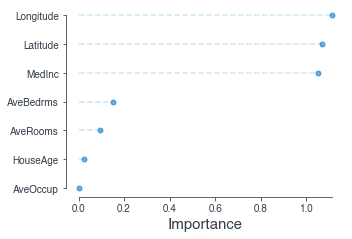

In [79]:
X, y = cali()
plot_importances(auto_selection(X,y, LinearRegression, r2_score, imp_type=perm_imp))

Best score 0.8093868178118787
Final features: 7/8


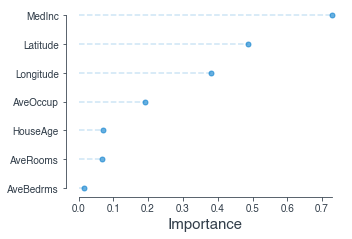

In [80]:
plot_importances(auto_selection(X,y, RandomForestRegressor, 
                                r2_score, imp_type=perm_imp, iterations=10))

Best score 0.8001668304943147
Final features: 6/8


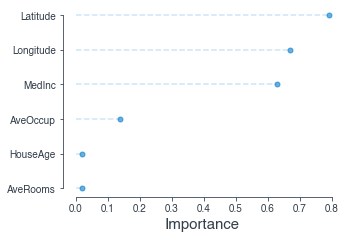

In [81]:
plot_importances(auto_selection(X,y, GradientBoostingRegressor, 
                                r2_score, imp_type=perm_imp, iterations=10))

In [82]:
X.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

In these cases, we see that Random Forest and Gradient Boosting eliniated the same two features, population and AveBedrms.

 Now we will explore some other techniqeus and libraries for feature importance. 

# Shap 

Shap is a feature importance library that claims to work for any aribtirary black box model. It's output is "Shap values", which are feature importance values generated using a game theoretic approach. The intuition for how these values are generated is then sort of a black box! Nonetheless, there is some value in comparing Shap with our feature importance techniques we have implemented above.

Most of this code is from their front page on git: https://github.com/slundberg/shap

In [83]:
import xgboost
import shap


shap.initjs()
X,y = shap.datasets.boston()
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

(These figures don't render via pdf, but they appear in the .ipynb)

Shap is optimized for gradient boosting models. Here XGBoost creates predictions which Shap then calculates importances with. The image is telling us that LSTAT has a Shap value of 4.98, and the red indicates that feature pushing the value of the target higher. 

RM on the other hand is in blue, indicating pushing the value of the target prediction lower.

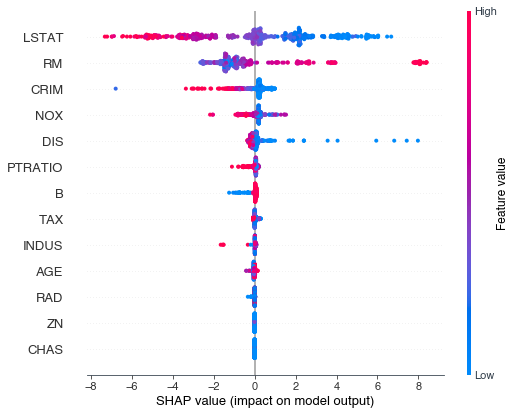

In [84]:
shap.summary_plot(shap_values, X)

This graph shows how different Shap values for each feature interact with the target. LSTAT has values that are red with lower Shap values. Unimportant features do not have a wide spread of Shap values, i.e. CHAS at the bottom.

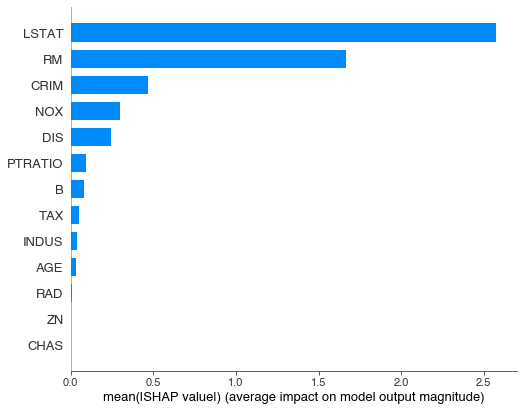

In [85]:
shap.summary_plot(shap_values, X, plot_type="bar")

This graph is the mean of the shap values for each feature, giving us perhaps the easiest way to visualize importance from the Shap library. It generally agrees with what observed with permuation and drop column, but doesn't tell us if the model will be better if we dropped some of the columns (missing the idea of negative feature importance).

## Shap for California Housing

In [7]:
import xgboost
import shap

shap.initjs()
X,y = cali()
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

(These figures don't render via pdf, but they appear in the .ipynb)

Shap also agrees here with our previous techniques, showing that MedInc pushes housing value high. 

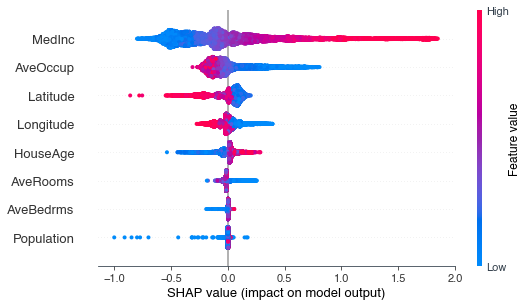

In [87]:
shap.summary_plot(shap_values, X)

Latitude and Longitude are correctly given higher impact together, since they are correlated.

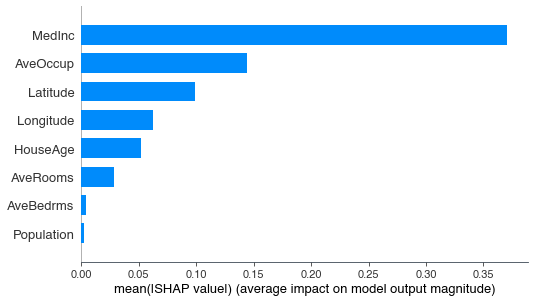

In [88]:
shap.summary_plot(shap_values, X, plot_type="bar")

Most of our previous techniques did not place AveOccup above latitude and longitude, so there is some difference when looking at the average Shap value plot.

# Lime 

Lime is feature importance library that works with any model, and uses linear models to understand the output of the model. According to their github: "Intuitively, an explanation is a local linear approximation of the model's behaviour."

The 'L' in Lime stands for Local, and what this is what differentias it from other feature importance techniques. It looks at predictions at one observation at a time, fitting a linear model to the local prediction space. Noteably, this is not a global feature importance, and is only useful when looking at one prediction at a time.

Code for the tabular model is from their [tutorial](https://marcotcr.github.io/lime/tutorials/Using%2Blime%2Bfor%2Bregression.html)

In [262]:
import lime
import lime.lime_tabular

In [263]:
boston = load_boston()

In [264]:
rf = RandomForestRegressor(n_estimators=1000)

In [265]:
train, test, labels_train, labels_test = train_test_split(boston.data, boston.target, train_size=0.80)

In [266]:
rf.fit(train, labels_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [267]:
categorical_features = np.argwhere(np.array([len(set(boston.data[:,x])) for x in range(boston.data.shape[1])]) <= 10).flatten()

In [268]:
explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=boston.feature_names, 
                                                   class_names=['price'], categorical_features=categorical_features, verbose=True, mode='regression')

In [269]:
i = 25
exp = explainer.explain_instance(test[i], rf.predict, num_features=5)

Intercept 25.096379688420505
Prediction_local [18.79469936]
Right: 18.81019999999996


In [270]:
exp.show_in_notebook(show_table=True)

(These figures don't render via pdf, but they appear in the .ipynb)

We are looking at on instance, index 25 in the test set. For this example, the feature PTRATIO has a postive impact on the predicted value, while our usual features LSTAT and RM and pulling down the predictied value.

The figure on the far left is showing the range of possible prediciton values, and is showing that the linear model lime is using predicted 18.79 while the random forest predicted 18.8. The middle figure gives a visual way to see which features are pulling the predicted value higher or lower, with blue and orange respectively. 

This is not disagreeing with our feature importance techniques from above, but instead giving us a local interpretation of what a model is using to make a prediction on one observation.

## LIME with California Housing

In [271]:
X, y = cali()

rf = RandomForestRegressor()

train, test, labels_train, labels_test = train_test_split(X, y, train_size=0.80)

train = train.to_numpy()
test = test.to_numpy()

rf.fit(train, labels_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [272]:
explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=list(X.columns), verbose=True, mode='regression')

In [275]:
i = 2
exp = explainer.explain_instance(test[i], rf.predict, num_features=8)

Intercept 1.785491617581184
Prediction_local [3.91510512]
Right: 3.3185000000000002


In [276]:
exp.show_in_notebook(show_table=True)

(These figures don't render via pdf, but they appear in the .ipynb)

With the california housing data set, we look at index 2 of the test set. This agrees with what we have seen before with other feature importance techniques, in that for high values of MedInc, the prediction is pulled higher.

# Partial Dependence Plots 

What feature importance tells us is a single value that can be used for comparison or model selection purposes. However, this value does not tell us how *changing* the value of each feature affects the target. It could be helpful to know whether the feature affects the target in a monotonically increasing or decreasing way. 

The spearman's rank coefficient gave us a hint at that via correlation, for example that LSTAT has negative correlation with the target. For RM, there was a positive correlation.

Let's look at sklearn's partial depennce plot function:

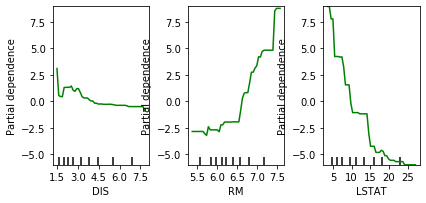

In [5]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(
    boston.data, boston.target.tolist(),random_state=0)
gbrt = GradientBoostingRegressor().fit(X_train, y_train)
fig, axs = plot_partial_dependence(
    gbrt, X_train, np.argsort(gbrt.feature_importances_)[-3:],
    feature_names=boston.feature_names.tolist(), n_jobs=3,
    grid_resolution=50)




On the X-axis is our different values that are being tried for each feature, and on the Y-axis is the depence of the target value. It is only computed using that feature, hence it being a "partial" dependence with that feature. 

From these partial dependence plot we can see that the DIS feature is flat, and therefore does not affect the how the target changes, while for RM, and the number of rooms increase, the target increases. For LSTAT, we see that as it increases, the target value decreases dramatically, confirmining our intuition from spearman's correlation.

The values generating the line plot are an average of many target features. Sometimes, even with a flat partial dependence plot, there still can be a significant relationship. It would be helpful to see not just the average partial dependence, but also all of the samples used to generate that average. That's what the PDP box package creates for us:

# PDP Box


In [177]:
from pdpbox import pdp, get_dataset, info_plots

In [178]:
X, y = boston()
model = RandomForestRegressor()
model.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [179]:
boston_data = X
boston_data['MEDV'] = y 
boston_features = list(X.columns)
boston_model = model
boston_target = 'MEDV'

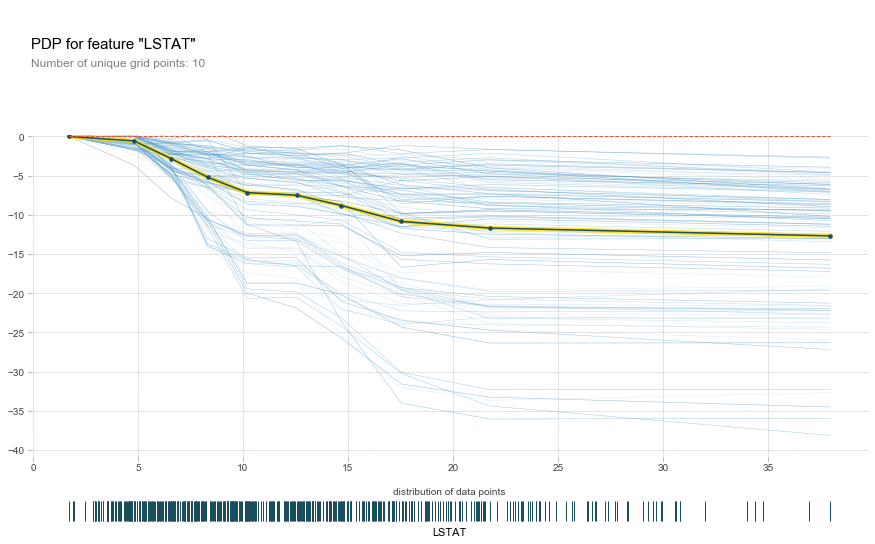

In [156]:
pdp_lstat = pdp.pdp_isolate(
            model=boston_model, dataset=boston_data, model_features=boston_features, feature='LSTAT')
fig, axes = pdp.pdp_plot(pdp_lstat, 'LSTAT', plot_lines=True, frac_to_plot=100, plot_pts_dist=True)

This partial dependence plot agrees with what the sklearn plot showed, but gives us the added insight out how all the samples contribute to the average line, the darkest line. It shows there is a strong decreasing relationship with the target value for the feature LSTAT. 

In addition, pdpbox gives us the distribtuion of datapoints at the bottom of the graph. We observe that the majority of LSTAT values fall between 5 and 20.

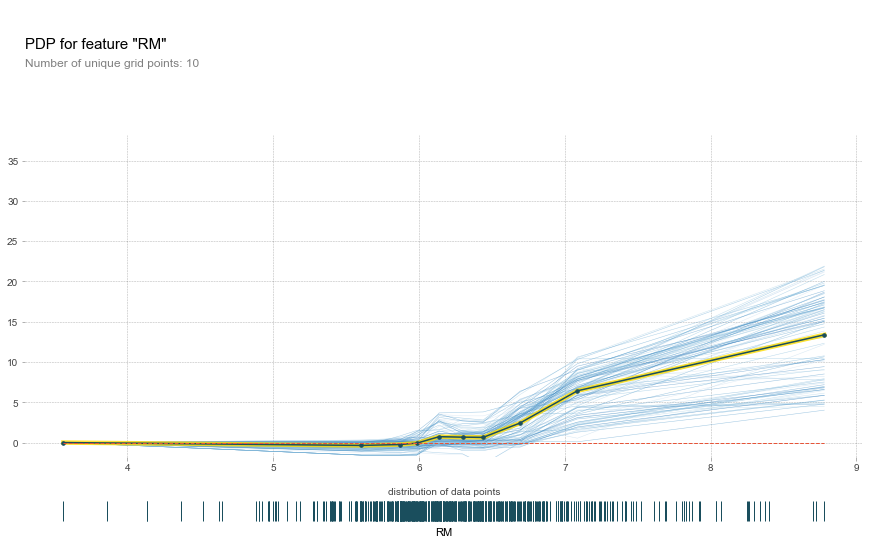

In [157]:
pdp_RM = pdp.pdp_isolate(
            model=boston_model, dataset=boston_data, model_features=boston_features, feature='RM')
fig, axes = pdp.pdp_plot(pdp_RM, 'RM', plot_lines=True, frac_to_plot=100, plot_pts_dist=True)

For RM, we also observe a strong postive relationship wih the target value, which agrees with our previous feature importance techniques.

## PDP box for California Housing

In [159]:
X, y = cali()
model = RandomForestRegressor()
model.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [160]:
cali_data = X
cali_features = list(X.columns)
cali_model = model

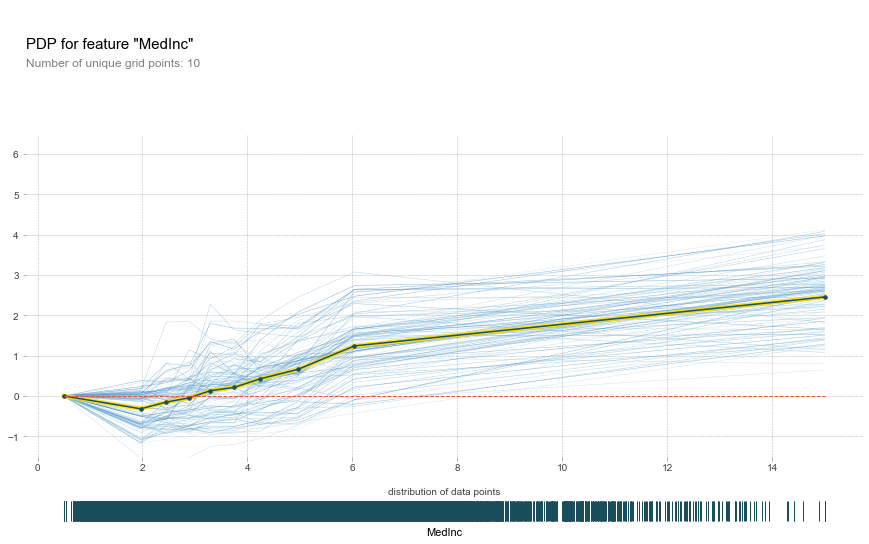

In [162]:
pdp_MedInc = pdp.pdp_isolate(
            model=cali_model, dataset=cali_data, model_features=cali_features, feature='MedInc')
fig, axes = pdp.pdp_plot(pdp_MedInc, 'MedInc', plot_lines=True, frac_to_plot=100, plot_pts_dist=True)

As expected, MedInc has a strong positve relationship with the target value, but we do see decreasing behavior for values between 0 and 2. 

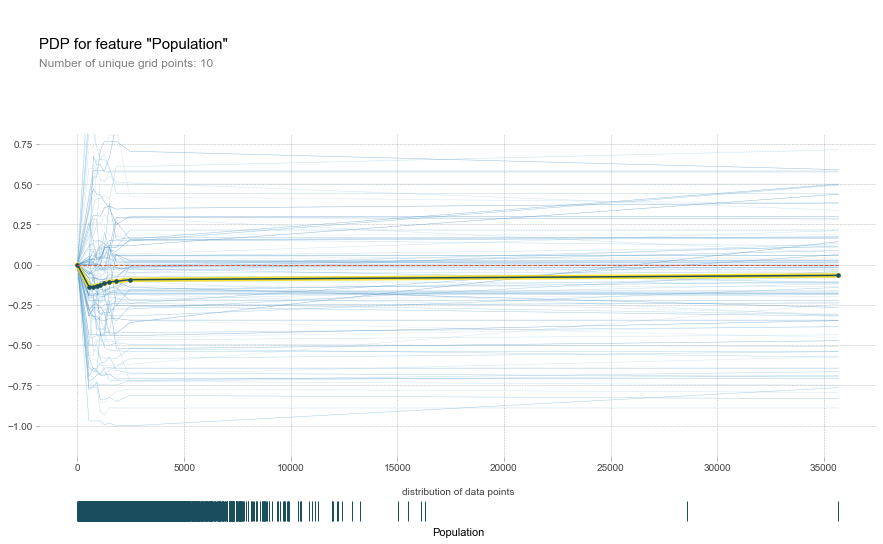

In [165]:
pdp_Population = pdp.pdp_isolate(
            model=cali_model, dataset=cali_data, model_features=cali_features, feature='Population')
fig, axes = pdp.pdp_plot(pdp_Population, 'Population', plot_lines=True, frac_to_plot=100, plot_pts_dist=True)

Population was identified as a unimportant feature with almost all the techniques we tried, and here we also see the there is not change in the target value with changes in population.

# Conclusion

Through this report, we explored numerous feature importance techniques. Some did not involve models, like spearman's correlation and PCA, while drop column and permuation importance both utilze models and metrics to determine importance. 

Using statistical techniques like empirical P-values and error bars, we were able to understand how much we can trust that these feature importance values we not just created by chance.

We implemented an auto feature selection algorithm, which gave a clear application into how feature importance techniques can aid in our model selection processes.

We explored various feature importance packages and saw how they compared with our hand implemented feature importance techniques.

A takeway from this analysis is that one should not just use a single technique to evaluate feature importance. By using a handful of techniques, we get different persepectives on what is deemed 'important'. 